# Tests Simu budget

In [1]:
# Activate multi-output in notebook
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import unittest

import numpy as np
import pandas as pd

tc = unittest.TestCase()

In [3]:
base_server_plf_2022 = "/mnt/data-out/leximpact/leximpact-server/data_erfs_2018_aged_to_2021-PROD-PLF2022.h5"
sample_pop = pd.read_hdf(base_server_plf_2022)
sample_pop["weight_foyers"] = sample_pop["wprm"]
sample_pop["weight_individus"] = sample_pop["wprm"]

In [4]:
sample_pop.sample(10)
# sample_pop.columns

age  categorie_salarie  chomage_brut  contrat_de_travail  \
58493    71                  7           0.0                   6   
86437     5                  7           0.0                   6   
80849    56                  0           0.0                   0   
90098     9                  7           0.0                   6   
68841    88                  7           0.0                   6   
90409    10                  7           0.0                   6   
24094    51                  0           0.0                   0   
74223    10                  7           0.0                   6   
86144    65                  7           0.0                   6   
102551    8                  0           0.0                   1   

        heures_remunerees_volume  idfam  idfoy  idmen  \
58493                   0.000000  29696  29696  26494   
86437                   0.000000  43820  43820  39110   
80849                   0.000000  40980  40980  36566   
90098                   0.000000  45674  45674  40759   
68841                   0.000000  34951  34951  31213   
90409                   0.000000  45835  45835  40900   
24094                   0.000000  12272  12272  10970   
74223                   0.000000  37673  37673  33635   
86144                   0.000000  43675  43675  38982   
102551                249.952392  52032  52032  46428   

        pensions_alimentaires_percues  quifam  quifoy  retraite_brute  \
58493                             0.0       1       1           13470   
86437                             0.0       2       2               0   
80849                             0.0       1       1               0   
90098                             0.0       2       2               0   
68841                             0.0       0       0           14110   
90409                             0.0       2       2               0   
24094                             0.0       0       0               0   
74223                             0.0       2       2               0   
86144                             0.0       0       0           24050   
102551                            0.0       2       2               0   

        statut_marital  salaire_de_base  taux_csg_remplacement         f4ba  \
58493                1         0.000000                      3          NaN   
86437                2         0.000000                      0          NaN   
80849                1     32437.753711                      0          NaN   
90098                2         0.000000                      0          NaN   
68841                1         0.000000                      3          NaN   
90409                2         0.000000                      0          NaN   
24094                1     61757.106359                      0  3898.788166   
74223                2         0.000000                      0          NaN   
86144                1         0.000000                      3  6505.769887   
102551               2      2561.596187                      0          NaN   

               wprm  weight_foyers  weight_individus  
58493    275.572399     275.572399        275.572399  
86437    660.402578     660.402578        660.402578  
80849    530.507218     530.507218        530.507218  
90098    807.293593     807.293593        807.293593  
68841    461.310625     461.310625        461.310625  
90409    566.926478     566.926478        566.926478  
24094    661.616554     661.616554        661.616554  
74223    790.297938     790.297938        790.297938  
86144   1020.953251    1020.953251       1020.953251  
102551   745.380851     745.380851        745.380851

In [5]:
# salaires = [0, 8_800, 12_000, 16_000, 19_000, 23_800, 30_000, 38_000, 50_000, 150_000]
rfr_min_decile = [
    0,
    2_264,
    8_816,
    12_854,
    16_199,
    19_450,
    23_865,
    30_112,
    38_713,
    54_548,
]
# Montant correspondant au RFR moyen
rfr_moyen_decile = [
    268,
    5_943,
    10_943,
    14_664,
    17_780,
    21_443,
    26_953,
    34_107,
    45_579,
    99_492,
]
dataset = []
salaires = []

default_foyer = {
    "age": 25,
    "categorie_salarie": 0,
    "contrat_de_travail": 1,
    "heures_remunerees_volume": 1_607,
    "idfam": 0,
    "idfoy": 0,
    "idmen": 0,
    "quifam": 0,
    "quifoy": 0,
    "statut_marital": 1,
    "salaire_de_base": 0,
    "weight_foyers": 3_800_000,
}
count = 0
# Pour les déciles qui paient des impôts il faut
for i, rfr_moyen in enumerate(rfr_moyen_decile):
    rfr_min = rfr_min_decile[i]
    rfr_max = rfr_min_decile[i + 1] if i < 9 else 15_000_000

    print(
        f"Pour le décile {i+1} il a un rfr moyen de {rfr_moyen} et un rfr min de {rfr_min} et max de {rfr_max}"
    )
    # On donne le min*10% au premier individu et le max au deuxième
    salarie_min = default_foyer.copy()
    salarie_min["idfam"] = count
    salarie_min["idfoy"] = salarie_min["idfam"]
    salarie_min["idmen"] = salarie_min["idfam"]
    facteur_min = (rfr_moyen - rfr_max) / (rfr_min - rfr_max)
    salarie_min["salaire_de_base"] = rfr_min
    salarie_min["weight_foyers"] = default_foyer["weight_foyers"] * facteur_min
    count += 1

    salarie_max = default_foyer.copy()
    salarie_max["idfam"] = count
    salarie_max["idfoy"] = salarie_max["idfam"]
    salarie_max["idmen"] = salarie_max["idfam"]
    salarie_max["salaire_de_base"] = rfr_max
    salarie_max["weight_foyers"] = default_foyer["weight_foyers"] * (1 - facteur_min)

    count += 1

    # On réparti les poids pour obtenir la moyenne
    dataset.append(salarie_min)
    dataset.append(salarie_max)
df = pd.DataFrame(dataset)
df["wprm"] = df.weight_foyers
df["weight_individus"] = df.weight_foyers
df
tc.assertEqual(df.weight_foyers.sum(), default_foyer["weight_foyers"] * 10)
tc.assertAlmostEqual(
    (df.salaire_de_base * df.weight_foyers).sum(), 1_053 * 1e9, delta=500 * 1e6
)

Pour le décile 1 il a un rfr moyen de 268 et un rfr min de 0 et max de 2264
Pour le décile 2 il a un rfr moyen de 5943 et un rfr min de 2264 et max de 8816
Pour le décile 3 il a un rfr moyen de 10943 et un rfr min de 8816 et max de 12854
Pour le décile 4 il a un rfr moyen de 14664 et un rfr min de 12854 et max de 16199
Pour le décile 5 il a un rfr moyen de 17780 et un rfr min de 16199 et max de 19450
Pour le décile 6 il a un rfr moyen de 21443 et un rfr min de 19450 et max de 23865
Pour le décile 7 il a un rfr moyen de 26953 et un rfr min de 23865 et max de 30112
Pour le décile 8 il a un rfr moyen de 34107 et un rfr min de 30112 et max de 38713
Pour le décile 9 il a un rfr moyen de 45579 et un rfr min de 38713 et max de 54548
Pour le décile 10 il a un rfr moyen de 99492 et un rfr min de 54548 et max de 15000000


age  categorie_salarie  contrat_de_travail  heures_remunerees_volume  \
0    25                  0                   1                      1607   
1    25                  0                   1                      1607   
2    25                  0                   1                      1607   
3    25                  0                   1                      1607   
4    25                  0                   1                      1607   
5    25                  0                   1                      1607   
6    25                  0                   1                      1607   
7    25                  0                   1                      1607   
8    25                  0                   1                      1607   
9    25                  0                   1                      1607   
10   25                  0                   1                      1607   
11   25                  0                   1                      1607   
12   25                  0                   1                      1607   
13   25                  0                   1                      1607   
14   25                  0                   1                      1607   
15   25                  0                   1                      1607   
16   25                  0                   1                      1607   
17   25                  0                   1                      1607   
18   25                  0                   1                      1607   
19   25                  0                   1                      1607   

    idfam  idfoy  idmen  quifam  quifoy  statut_marital  salaire_de_base  \
0       0      0      0       0       0               1                0   
1       1      1      1       0       0               1             2264   
2       2      2      2       0       0               1             2264   
3       3      3      3       0       0               1             8816   
4       4      4      4       0       0               1             8816   
5       5      5      5       0       0               1            12854   
6       6      6      6       0       0               1            12854   
7       7      7      7       0       0               1            16199   
8       8      8      8       0       0               1            16199   
9       9      9      9       0       0               1            19450   
10     10     10     10       0       0               1            19450   
11     11     11     11       0       0               1            23865   
12     12     12     12       0       0               1            23865   
13     13     13     13       0       0               1            30112   
14     14     14     14       0       0               1            30112   
15     15     15     15       0       0               1            38713   
16     16     16     16       0       0               1            38713   
17     17     17     17       0       0               1            54548   
18     18     18     18       0       0               1            54548   
19     19     19     19       0       0               1         15000000   

    weight_foyers          wprm  weight_individus  
0    3.350177e+06  3.350177e+06      3.350177e+06  
1    4.498233e+05  4.498233e+05      4.498233e+05  
2    1.666270e+06  1.666270e+06      1.666270e+06  
3    2.133730e+06  2.133730e+06      2.133730e+06  
4    1.798366e+06  1.798366e+06      1.798366e+06  
5    2.001634e+06  2.001634e+06      2.001634e+06  
6    1.743797e+06  1.743797e+06      1.743797e+06  
7    2.056203e+06  2.056203e+06      2.056203e+06  
8    1.952015e+06  1.952015e+06      1.952015e+06  
9    1.847985e+06  1.847985e+06      1.847985e+06  
10   2.084621e+06  2.084621e+06      2.084621e+06  
11   1.715379e+06  1.715379e+06      1.715379e+06  
12   1.921594e+06  1.921594e+06      1.921594e+06  
13   1.878406e+06  1.878406e+06      1.878406e+06  
14   2.034973e+06  2.034973e+0

In [6]:
# Données entrées
a = 10
b = 20
M = 12
P = 200

# Poids à trouver
fa = 0.8

# Calcul
fb = 1 - fa
a * fa
b * fb
pa = P * fa
pb = P * fb
m = (a * pa + b * pb) / (pa + pb)
m
assert M == m
assert pa + pb == P

# Comment trouver ce fa=0,8 ?
assert M == (P * M) / P
# => P ne sert pas dans l'équation, ouf
# Nous cherchons donc fa
assert m == (a * fa + b * fb) / (fa + fb)
assert m == (a * fa + b * (1 - fa)) / (fa + (1 - fa))
assert m * (fa + (1 - fa)) == a * fa + b * (1 - fa)
assert m * fa + m * 1 - m * fa == a * fa + b * 1 - b * fa
assert m * fa + m * 1 - m * fa == a * fa + b * 1 - b * fa
assert m == fa * (a - b) + b
assert m - b == fa * (a - b)
assert (m - b) / (a - b) == fa
# Solution : (m-b)/(a-b)

8.0

3.999999999999999

12.0

In [7]:
M = 10_943.887205684432
P = 3_981_823
A = 8_816
B = 12_854

fa = (M - B) / (A - B)
fa
fb = 1 - fa
A * fa
B * fb
pa = P * fa
pb = P * fb
m = (A * pa + B * pb) / (pa + pb)
m
assert M == m
assert pa + pb == P

0.4730343720444695

4170.271023944043

6773.616181740389

10943.887205684432

In [8]:
# dataset = []
# nb_premier_jeu = 10
# for i in range(nb_premier_jeu):
#     dataset.append(
#         [
#             20,
#             0,
#             1,
#             1_607,
#             i,
#             i,
#             i,
#             0,
#             0,
#             1,
#             salaires[i % nb_premier_jeu],
#             3_800_000,
#             3_800_000,
#             3_800_000,
#         ]
#     )
# salaires2 = [
# for s in salaires:

# salaires2 = [268, 5_943, 10_943, 14_664, 17_780, 21_443, 26_953, 34_107, 45_579, 99_492]
# for i in range(nb_premier_jeu):
#     dataset.append(
#         [
#             20,
#             0,
#             1,
#             1_607,
#             i + nb_premier_jeu,
#             i + nb_premier_jeu,
#             i + nb_premier_jeu,
#             0,
#             0,
#             1,
#             salaires2[(i - nb_premier_jeu) % nb_premier_jeu] * 2,
#             3_800_000,
#             3_800_000,
#             3_800_000,
#         ]
#     )
# df = pd.DataFrame(
#     dataset,
#     columns=[
#         "age",
#         "categorie_salarie",
#         "contrat_de_travail",
#         "heures_remunerees_volume",
#         "idfam",
#         "idfoy",
#         "idmen",
#         "quifam",
#         "quifoy",
#         "statut_marital",
#         "salaire_de_base",
#         "wprm",
#         "weight_foyers",
#         "weight_individus",
#     ],
# )
# df
# print(f"Somme des salaires : {(df.salaire_de_base * df.wprm).sum():,.0f} €")

In [9]:
df.to_hdf(
    "/mnt/data-out/leximpact/data_very_small_dataset.h5", key="very_small_dataset"
)
# Il faut relancer le kernel après un changement pour que le module simu_budget soit rechargé.

In [11]:
!ls /mnt/data-out/leximpact/data_very_small_dataset.h5

/mnt/data-out/leximpact/data_very_small_dataset.h5


## test de la base

In [10]:
import os

# On force la config, ce sera prioritaire sur le .env
os.environ["ERFS_FINAL_FOR_SIMU"] = "/mnt/data-out/leximpact/data_very_small_dataset.h5"

In [29]:
from openfisca_france import FranceTaxBenefitSystem

from leximpact_socio_fisca_simu_etat.compare_before_after import compare_before_after
from leximpact_socio_fisca_simu_etat.quantiles import plot_quantile, quantile_to_df
from leximpact_socio_fisca_simu_etat.schema import (
    AllSimulationResult,
    OneSimulationResult,
    ReformeSocioFiscale,
)
from leximpact_socio_fisca_simu_etat.simu_budget import (
    compute_all_simulation,
    compute_reform,
)

## Test problème gagnant / perdant

In [31]:
annee_de_calcul = 2023
variables = ["irpp"]
reform_base = ReformeSocioFiscale(
    base=annee_de_calcul,
    amendement={},
    output_variables=variables,
    quantile_base_variable=None,
    quantile_nb=0,
    quantile_compare_variables=None,
)
# Compute the value with Open Fisca
TBS = FranceTaxBenefitSystem()
resultat, errors, data_base = compute_reform(
    reform_base, annee_de_calcul, ignore_recalage=True, tax_benefit_system=TBS
)
# Check there is no error
tc.assertEqual(errors, [])
of_result = 0
for v in variables:
    of_result += resultat.state_budget[v]
# Print an output
print(
    f"Montant en sortie OF pour {annee_de_calcul} pour la somme de {variables} : {of_result:,.0f}"
)

[leximpact_socio-fisca-simu-etat DEBUG @ 17:09:37] OpenFisca a retourné des foyer_fiscal pour irpp en 2023.
[leximpact_socio-fisca-simu-etat DEBUG @ 17:09:37] Total avant correction de irpp : -85,897,805,451
[leximpact_socio-fisca-simu-etat WARNING @ 17:09:37] ignore_recalage=True => Pas de recalage des données.


Montant en sortie OF pour 2023 pour la somme de ['irpp'] : -85,897,805,451


In [27]:
annee_de_calcul = 2023
variables = ["irpp"]
reform_amdt = ReformeSocioFiscale(
    base=annee_de_calcul,
    amendement={
        "impot_revenu.calcul_impot_revenu.plaf_qf.decote.seuil_celib": 0,
        "impot_revenu.calcul_impot_revenu.plaf_qf.decote.seuil_couple": 0,
    },
    output_variables=variables,
    quantile_base_variable=None,
    quantile_nb=0,
    quantile_compare_variables=None,
)
# Compute the value with Open Fisca
TBS = FranceTaxBenefitSystem()
resultat, errors, data_amdt = compute_reform(
    reform_amdt, annee_de_calcul, ignore_recalage=True, tax_benefit_system=TBS
)
# Check there is no error
tc.assertEqual(errors, [])
of_result = 0
for v in variables:
    of_result += resultat.state_budget[v]
# Print an output
print(
    f"Montant en sortie OF pour {annee_de_calcul} pour la somme de {variables} : {of_result:,.0f}"
)

[leximpact_socio-fisca-simu-etat DEBUG @ 17:07:43] OpenFisca a retourné des foyer_fiscal pour irpp en 2023.
[leximpact_socio-fisca-simu-etat DEBUG @ 17:07:43] Total avant correction de irpp : -91,595,708,476
[leximpact_socio-fisca-simu-etat WARNING @ 17:07:43] ignore_recalage=True => Pas de recalage des données.


Montant en sortie OF pour 2023 pour la somme de ['irpp'] : -91,595,708,476


In [35]:
comp = compare_before_after(data_base, data_amdt)
comp
tc.assertGreater(comp.non_zero_after, comp.non_zero_before)

CompareBeforeAfter(total=38000000, non_zero_before=5447666, non_zero_after=13278405, above_after=5436239, lower_after=0, neutral=32563760, tolerance_factor_used=1.05)

In [38]:
# data_amdt['irpp']

In [39]:
# data_plf

In [40]:
%%time
# "prelevements_sociaux.contributions_sociales.csg.activite.imposable.taux": 0.05
reform_quantile_rfr = ReformeSocioFiscale(
    base=2023,
    amendement={
        "impot_revenu.calcul_impot_revenu.plaf_qf.decote.seuil_celib": 0,
        "impot_revenu.calcul_impot_revenu.plaf_qf.decote.seuil_couple": 0,
    },
    output_variables=["rfr", "irpp"],
    quantile_nb=10,
    quantile_base_variable=["rfr"],
    quantile_compare_variables=[
        "irpp",
    ],
)
resultat_quantile_rfr = compute_all_simulation(
    reform_quantile_rfr, ignore_recalage=True
)

[leximpact_socio-fisca-simu-etat DEBUG @ 17:24:27] OpenFisca a retourné des foyer_fiscal pour rfr en 2023.
[leximpact_socio-fisca-simu-etat DEBUG @ 17:24:27] Total avant correction de rfr : 809,736,139,289
[leximpact_socio-fisca-simu-etat WARNING @ 17:24:27] ignore_recalage=True => Pas de recalage des données.
[leximpact_socio-fisca-simu-etat DEBUG @ 17:24:27] OpenFisca a retourné des foyer_fiscal pour irpp en 2023.
[leximpact_socio-fisca-simu-etat DEBUG @ 17:24:27] Total avant correction de irpp : -85,897,805,451
[leximpact_socio-fisca-simu-etat WARNING @ 17:24:27] ignore_recalage=True => Pas de recalage des données.
[leximpact_socio-fisca-simu-etat DEBUG @ 17:24:28] OpenFisca a retourné des foyer_fiscal pour rfr en 2023.
[leximpact_socio-fisca-simu-etat DEBUG @ 17:24:28] Total avant correction de rfr : 809,736,139,289
[leximpact_socio-fisca-simu-etat WARNING @ 17:24:28] ignore_recalage=True => Pas de recalage des données.
[leximpact_socio-fisca-simu-etat DEBUG @ 17:24:29] OpenFisca a

CPU times: user 2.6 s, sys: 8.82 ms, total: 2.61 s
Wall time: 2.6 s


In [41]:
resultat_quantile_rfr.result["amendement"].compare_before_after
comp = resultat_quantile_rfr.result["amendement"].compare_before_after
tc.assertGreater(comp.non_zero_after, comp.non_zero_before)

CompareBeforeAfter(total=38000000, non_zero_before=34649823, non_zero_after=34649823, above_after=0, lower_after=0, neutral=38000000, tolerance_factor_used=1.05)

AssertionError: 34649823 not greater than 34649823

## Test IRPP

In [13]:
reform = ReformeSocioFiscale(
    base=2023,
    output_variables=["irpp", "rfr"],
    quantile_nb=10,
    quantile_entity="foyer_fiscal",
    quantile_base_variable=["rfr"],
    quantile_compare_variables=["irpp"],
)
resultat = compute_all_simulation(reform, ignore_recalage=True)
resultat.result["base"].state_budget

[leximpact_socio-fisca-simu-etat DEBUG @ 16:45:27] OpenFisca a retourné des foyer_fiscal pour irpp en 2023.
[leximpact_socio-fisca-simu-etat DEBUG @ 16:45:27] Total avant correction de irpp : -85,897,805,451
[leximpact_socio-fisca-simu-etat WARNING @ 16:45:27] ignore_recalage=True => Pas de recalage des données.
[leximpact_socio-fisca-simu-etat DEBUG @ 16:45:27] OpenFisca a retourné des foyer_fiscal pour rfr en 2023.
[leximpact_socio-fisca-simu-etat DEBUG @ 16:45:27] Total avant correction de rfr : 809,736,139,289
[leximpact_socio-fisca-simu-etat WARNING @ 16:45:27] ignore_recalage=True => Pas de recalage des données.
[leximpact_socio-fisca-simu-etat DEBUG @ 16:45:27] Temps de traitement total pour la simulation 1.6394261047244072 secondes. Annee ERFS 2018 Annee TBS 2023


{'irpp': -85897805450.67339, 'rfr': 809736139289.0054}

In [19]:
df = quantile_to_df(resultat, "irpp")
df

quantile_num  fraction      count           rfr       rfr_sum  \
0           1.0       0.1  3981822.0  2.264000e+03  1.069235e+09   
1           2.0       0.2  3981823.0  8.816000e+03  2.366767e+10   
2           3.0       0.3  3981823.0  1.285400e+04  4.357662e+10   
3           4.0       0.4  3981822.0  1.619900e+04  5.839080e+10   
4           5.0       0.5  3981823.0  1.945000e+04  7.080063e+10   
5           6.0       0.6  3981823.0  2.386500e+04  8.538320e+10   
6           7.0       0.7  3981822.0  3.011200e+04  1.073257e+11   
7           8.0       0.8  3981823.0  3.871300e+04  1.358091e+11   
8           9.0       0.9  3981823.0  5.454800e+04  1.814896e+11   
9          10.0       1.0  3981823.0  1.000000e+15  3.961610e+11   

       rfr_mean  rfr_min       rfr_max  salaire_imposable  \
0    268.529101      0.0  2.264000e+03       8.352232e+08   
1   5943.927998   2264.0  8.816000e+03       1.852061e+10   
2  10943.887206   8816.0  1.285400e+04       3.410238e+10   
3  14664.343355  12854.0  1.619900e+04       4.569836e+10   
4  17780.959364  16199.0  1.945000e+04       5.918309e+10   
5  21443.244417  19450.0  2.386500e+04       6.304906e+10   
6  26953.918289  23865.0  3.011200e+04       8.399483e+10   
7  34107.259772  30112.0  3.871300e+04       1.062481e+11   
8  45579.536174  38713.0  5.454800e+04       1.422252e+11   
9  99492.362676  54548.0  1.000000e+15       3.289632e+11   

   salaire_imposable_sum  salaire_imposable_mean  salaire_imposable_min  \
0           8.352232e+08              219.795588                    0.0   
1           1.852061e+10             4873.845377                 1800.0   
2           3.410238e+10             8974.309585                 7200.0   
3           4.569836e+10            12025.885005                10000.0   
4           5.918309e+10            14661.490470                13000.0   
5           6.304906e+10            17693.687552                15000.0   
6           8.399483e+10            22103.901879                19000.0   
7           1.062481e+11            27960.032808                24000.0   
8           1.422252e+11            37427.697249                31000.0   
9           3.289632e+11            86569.271306                44000.0   

   salaire_imposable_max         avant  
0           1.800000e+03  8.352232e+08  
1           7.200000e+03  1.852061e+10  
2           1.000000e+04  3.410238e+10  
3           1.300000e+04  4.569836e+10  
4           1.500000e+04  5.918309e+10  
5           1.900000e+04  6.304906e+10  
6           2.400000e+04  8.399483e+10  
7           3.100000e+04  1.062481e+11  
8           4.400000e+04  1.422252e+11  
9           1.000000e+15  3.289632e+11

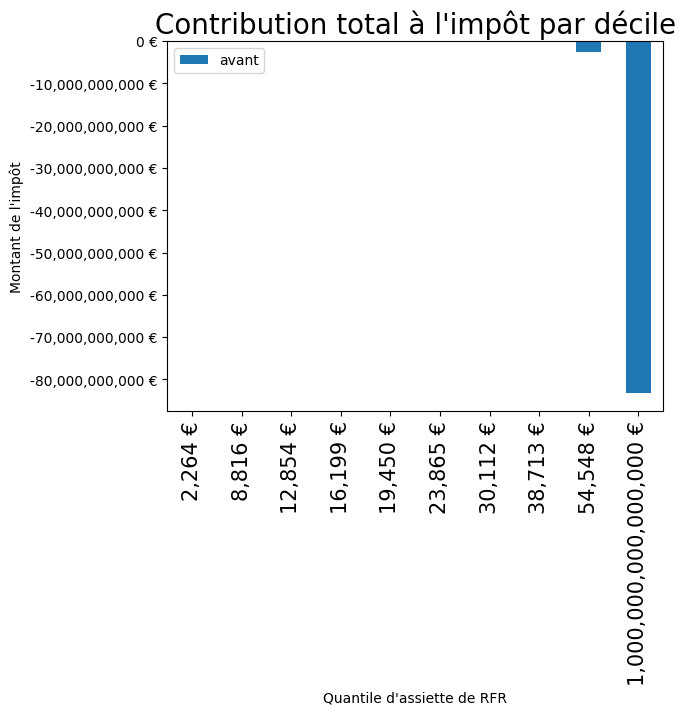

In [16]:
plot_quantile(
    df,
    x="rfr",
    y=["avant"],
    title="Contribution total à l'impôt par décile",
    xlabel="Quantile d'assiette de RFR",
    ylabel="Montant de l'impôt",
)

In [18]:
reform = ReformeSocioFiscale(
    base=2023,
    output_variables=["salaire_imposable", "rfr"],
    quantile_nb=10,
    quantile_entity="foyer_fiscal",
    quantile_base_variable=["rfr"],
    quantile_compare_variables=["salaire_imposable"],
)
resultat = compute_all_simulation(reform, ignore_recalage=True)
resultat.result["base"].state_budget

[leximpact_socio-fisca-simu-etat DEBUG @ 16:47:38] OpenFisca a retourné des individu pour salaire_imposable en 2023.
[leximpact_socio-fisca-simu-etat DEBUG @ 16:47:38] Total avant correction de salaire_imposable : 882,820,158,814
[leximpact_socio-fisca-simu-etat WARNING @ 16:47:38] ignore_recalage=True => Pas de recalage des données.
[leximpact_socio-fisca-simu-etat DEBUG @ 16:47:38] OpenFisca a retourné des foyer_fiscal pour rfr en 2023.
[leximpact_socio-fisca-simu-etat DEBUG @ 16:47:38] Total avant correction de rfr : 809,736,139,289
[leximpact_socio-fisca-simu-etat WARNING @ 16:47:38] ignore_recalage=True => Pas de recalage des données.
[leximpact_socio-fisca-simu-etat DEBUG @ 16:47:38] Temps de traitement total pour la simulation 1.5115627385675907 secondes. Annee ERFS 2018 Annee TBS 2023


{'salaire_imposable': 882820158813.7363, 'rfr': 809736139289.0054}

In [14]:
# resultat

In [19]:
df = quantile_to_df(resultat, "salaire_imposable")
df

quantile_num  fraction      count           rfr       rfr_sum  \
0           1.0       0.1  3981822.0  2.264000e+03  1.069235e+09   
1           2.0       0.2  3981823.0  8.816000e+03  2.366767e+10   
2           3.0       0.3  3981823.0  1.285400e+04  4.357662e+10   
3           4.0       0.4  3981822.0  1.619900e+04  5.839080e+10   
4           5.0       0.5  3981823.0  1.945000e+04  7.080063e+10   
5           6.0       0.6  3981823.0  2.386500e+04  8.538320e+10   
6           7.0       0.7  3981822.0  3.011200e+04  1.073257e+11   
7           8.0       0.8  3981823.0  3.871300e+04  1.358091e+11   
8           9.0       0.9  3981823.0  5.454800e+04  1.814896e+11   
9          10.0       1.0  3981823.0  1.000000e+15  3.961610e+11   

       rfr_mean  rfr_min       rfr_max  salaire_imposable  \
0    268.529101      0.0  2.264000e+03       8.352232e+08   
1   5943.927998   2264.0  8.816000e+03       1.852061e+10   
2  10943.887206   8816.0  1.285400e+04       3.410238e+10   
3  14664.343355  12854.0  1.619900e+04       4.569836e+10   
4  17780.959364  16199.0  1.945000e+04       5.918309e+10   
5  21443.244417  19450.0  2.386500e+04       6.304906e+10   
6  26953.918289  23865.0  3.011200e+04       8.399483e+10   
7  34107.259772  30112.0  3.871300e+04       1.062481e+11   
8  45579.536174  38713.0  5.454800e+04       1.422252e+11   
9  99492.362676  54548.0  1.000000e+15       3.289632e+11   

   salaire_imposable_sum  salaire_imposable_mean  salaire_imposable_min  \
0           8.352232e+08              219.795588                    0.0   
1           1.852061e+10             4873.845377                 1800.0   
2           3.410238e+10             8974.309585                 7200.0   
3           4.569836e+10            12025.885005                10000.0   
4           5.918309e+10            14661.490470                13000.0   
5           6.304906e+10            17693.687552                15000.0   
6           8.399483e+10            22103.901879                19000.0   
7           1.062481e+11            27960.032808                24000.0   
8           1.422252e+11            37427.697249                31000.0   
9           3.289632e+11            86569.271306                44000.0   

   salaire_imposable_max         avant  
0           1.800000e+03  8.352232e+08  
1           7.200000e+03  1.852061e+10  
2           1.000000e+04  3.410238e+10  
3           1.300000e+04  4.569836e+10  
4           1.500000e+04  5.918309e+10  
5           1.900000e+04  6.304906e+10  
6           2.400000e+04  8.399483e+10  
7           3.100000e+04  1.062481e+11  
8           4.400000e+04  1.422252e+11  
9           1.000000e+15  3.289632e+11

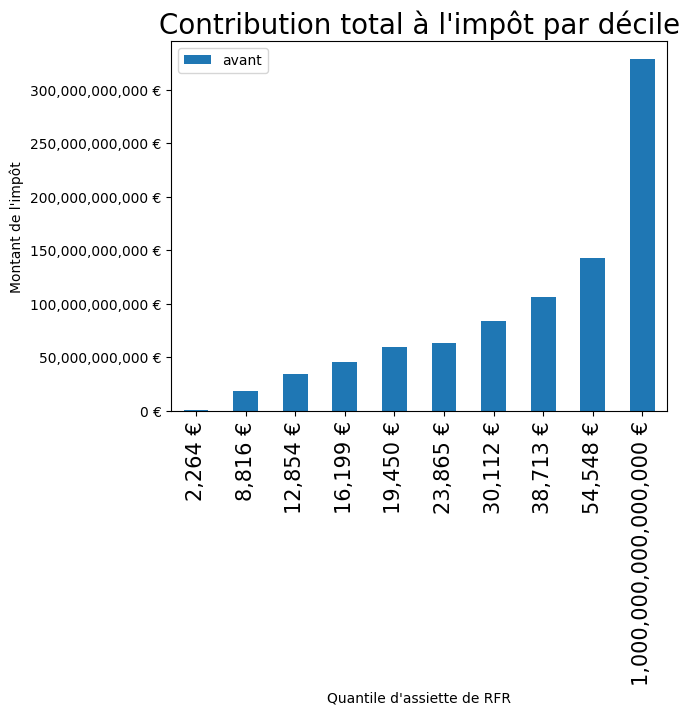

In [20]:
plot_quantile(
    df,
    x="rfr",
    y=["avant"],
    title="Contribution total à l'impôt par décile",
    xlabel="Quantile d'assiette de RFR",
    ylabel="Montant de l'impôt",
)